# Solving Ordinary Differential Equations
This notebook shows how to use `ode45` to compute the numerical solution to Ordinary Differential Equations (ODEs) in the form
\begin{equation}
\dot x = f(x,t),
\end{equation}
given the initial value condition $x(t_0)=x_0$. The arguments of the function `[t,x] = ode45(f,T,x0,options)` are as follows. 

**Inputs**
- `f`: a function handle describing $f(x,t)$,
- `T`: a vector identifying the boundaries of the time interval $T=[t_0,t_f]$,
- `x0`: a vector containing the initial conditions $x(t_0)$,
- `options`: a structure used to specify solver parameters _(Optional)_.
  
**Outputs**
- `t`: a vector containing an ordered sequence of time instants between $t_0$ and $t_f$,
- `x`: a matrix where each row is an estimate of $x(t)$ evaluated at the correponding row of `t`.


## Autonomous Systems
Consider the autonomous system $\dot x = f(x)$, with $x\in\mathbb R$ and 
\begin{equation}
f(x)=(1-|x|)x.
\end{equation}
To solve the system using `ode45`, it is important to note that the _Function Handle_ `f` must be defined in terms of two inputs (time `t` and state `x`), even though this particular system only depends on $x$. 

In [1]:
% Function Handle
f = @(t,x) (1-abs(x))*x;

Given the time interval $T=[0,10]$, we can use `ode45` to solve the ODE for the initial conditions $x_0=-2$.

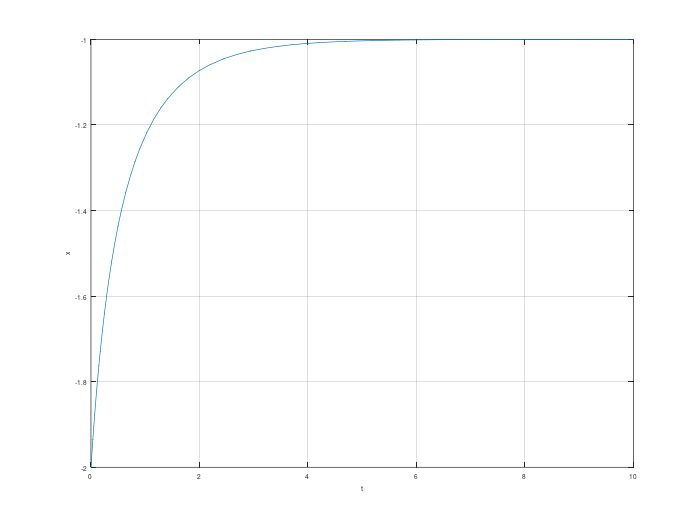

In [2]:
% Time Interval
T = [0,10];

% Initial Conditions
x0 = -2;

% Solve ODE
[t,x] = ode45(f,T,x0);

% Plot solution
plot(t,x); grid on
xlabel('t'); ylabel('x')

**Multiple Solutions:** It is possible to solve the ODE for a set of different initial conditions $x_0$ and overlay all of them on the same plot.

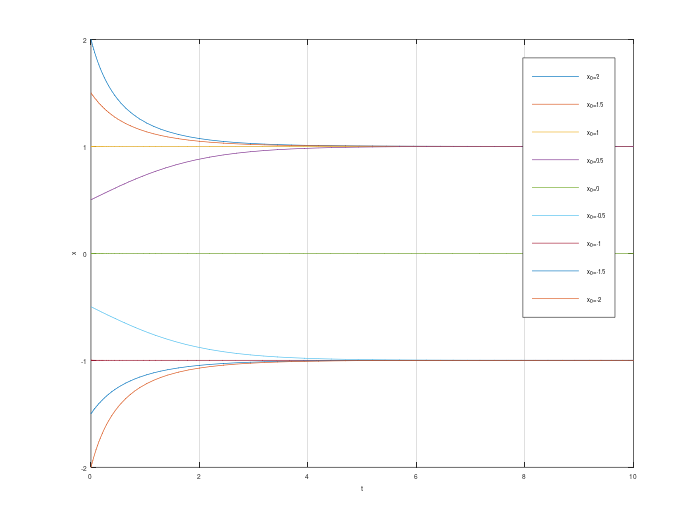

In [3]:
% Iterate over multiple initial conditions x0
for x0 = 2:-.5:-2

    % Solve ODE for the given x0
    [t,x] = ode45(f,T,x0);
    
    % Plot solution
    plot(t,x,'DisplayName',['x_0=' num2str(x0)]); hold on
end

xlabel('t'); ylabel('x'); legend; grid on

## Forced Systems
Consider the forced system $\dot x = g(x,u)$, with $x\in\mathbb R$, $u\in\mathbb R$, and
\begin{equation}
g(x,u)=(1-x)x+u.
\end{equation}
To solve the system, it is once again important to note that the input to `ode45` must be a function handle that depends on the time `t` and state `x`. As such, the input $u$ must also be written as a function of $t$ and/or $x$ before solving the ODE. 

### Time-varying Input
Given a time-varying input $u(t)=\sin(2\pi t)$, it is sufficient to define `u` as a function handle that depends on `t`. The call to `ode45` then relies on a new function handle `@(t,x) g(x,u(t))`, which is the composition of the system $g(x,u)$ and the signal $u(t)$.

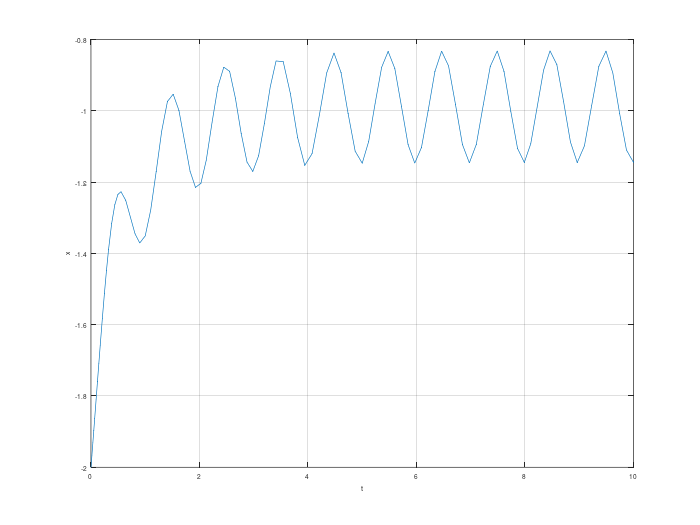

In [4]:
% System
g = @(x,u) (1-abs(x))*x+u;

% Time-varying input
u = @(t) sin(2*pi*t);

% Solve ODE
[t,x] = ode45(@(t,x) g(x,u(t)),T,x0);

% Plot solution
plot(t,x); grid on
xlabel('t'); ylabel('x')

**Improving Accuracy**: In this particular example, we note that the solution appears jagged. This is symptomatic of an insufficient accuracy of the ODE solver. The solution accuracy can be improved by using `optimset` to change the solver tolerance.

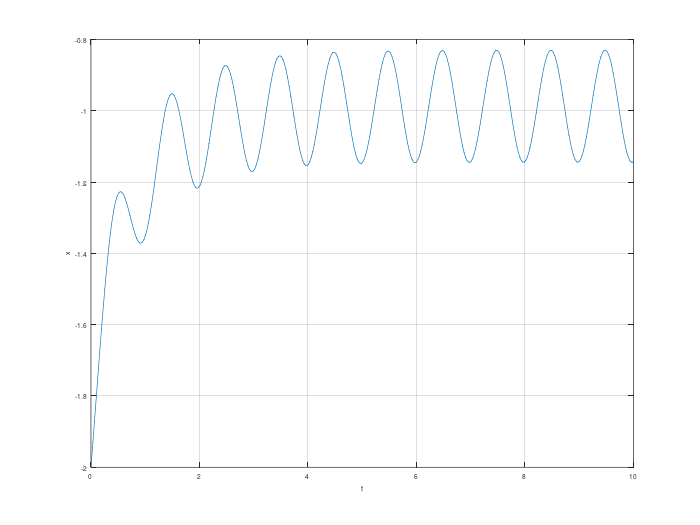

In [5]:
% Reduce Relative Tolerance
[t,x] = ode45(@(t,x) g(x,u(t)),T,x0,odeset('RelTol',1e-6));
plot(t,x); grid on
xlabel('t'); ylabel('x')

### Feedback Control
To implement a feedback law, e.g. $u(x)=-x$, it is sufficient to define `u` as a function handle that depends on the state `x`. The call to `ode45` then relies on a new function handle `@(t,x) g(x,u(x))`, which is the composition of the system $g(x,u)$ and the feedback law $u(x)$.

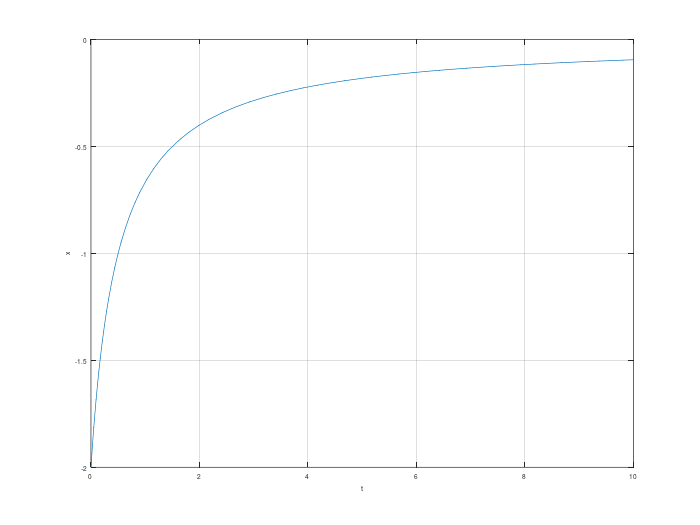

In [6]:
% System
g = @(x,u) (1-abs(x))*x+u;

% Feedback Law
u = @(x) -x;

% Solve ODE
[t,x] = ode45(@(t,x) g(x,u(x)),T,x0);

% Plot solution
plot(t,x); grid on
xlabel('t'); ylabel('x')

**Plotting the Control Input:** Given the solution $x(t)$, it is possible to plot the control input $u(t)$ by evaluating $u(x(t))$.

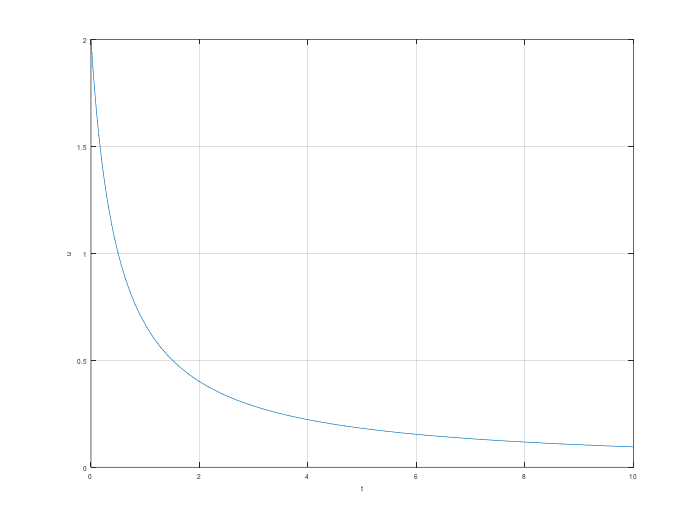

In [7]:
% Plot control input u(t) = -x(t)
plot(t,-x); grid on
xlabel('t'); ylabel('u')

## Higher-Order Systems
Systems with multiple states and inputs can be handled seamlessly using vector notation. For example, consider the system $\dot x = h(x,u)$, with $x\in\mathbb R^3$, $u\in\mathbb R^2$, and
\begin{equation}
h(x,u) = \begin{bmatrix} (1-|x_1|)x_1+\alpha x_3+u_1\\
x_3\\
-\omega^2\cos(x_3)+u_2
\end{bmatrix},
\end{equation}
where $\alpha=.2$ and $\omega=10$ are model parameters. We wish to solve the system over the time interval $T=[0,10]$, given the initial conditions $x_0=[1;2;0]$ and the inputs $u_1(t)=sin(\omega t)$ and $u_2(x)=-x_1x_3$.

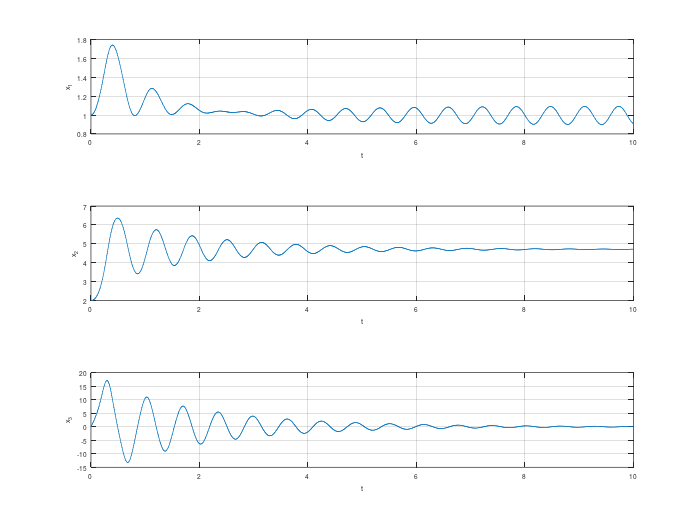

In [8]:
% Model Parameter
a = 0.2;
w = 10;

% System
h = @(x,u) [(1-abs(x(1)))*x(1)+.2*x(3)+u(1);
            x(3)
            -w^2*cos(x(2))+u(2)];

% Inputs
u = @(t,x) [sin(w*t)
            -x(1)*x(3)];

% Solve ODE
[t,x] = ode45(@(t,x) h(x,u(t,x)),[0,10],[1;2;0],odeset('RelTol',1e-6));

% Plot solution
subplot(3,1,1)
plot(t,x(:,1)); grid on
xlabel('t'); ylabel('x_1')

subplot(3,1,2)
plot(t,x(:,2)); grid on
xlabel('t'); ylabel('x_2')

subplot(3,1,3)
plot(t,x(:,3)); grid on
xlabel('t'); ylabel('x_3')

As before, the control input can be plotted by evaluating the fuctions $u_1(t)$ and $u_2(x(t))$ at every instant contained in the vector `t`. Note that the vector `u2` is computed using the _dot product_ `.*` to perform an element-wise multiplication of the vector `x(:,1)` and the vector `x(:,3)`. This is equivalent to computing `u2(k)=x(k,1)*x(k,3)` for each value `k=1:lenght(t)`.

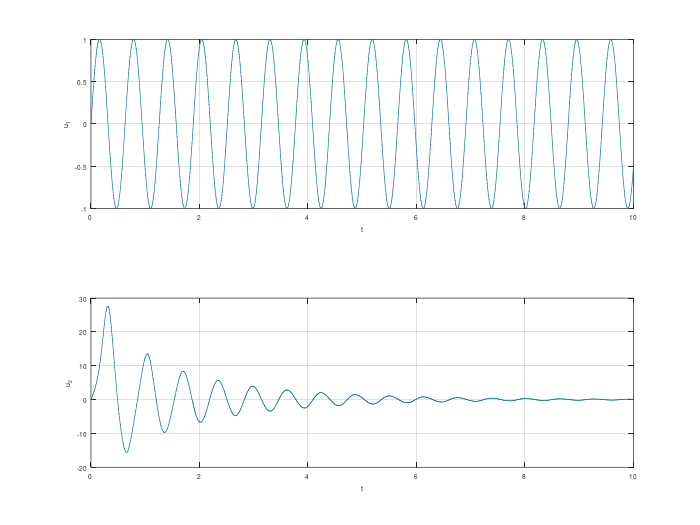

In [10]:
% Compute Input Singals
u1 = sin(w*t);
u2 = x(:,1).*x(:,3);

% Plot inputs
subplot(2,1,1)
plot(t,u1); grid on
xlabel('t'); ylabel('u_1')

subplot(2,1,2)
plot(t,u2); grid on
xlabel('t'); ylabel('u_2')

Rather than plotting $x(t)$ as three separate signals $x_i(t)$, in the special case where $x\in\mathbb R^3$ (or $\mathbb R^2)$, it can be interesting to plot the trajectory $x(t)$ on the coordinate axis $x_1,x_2,x_3$.

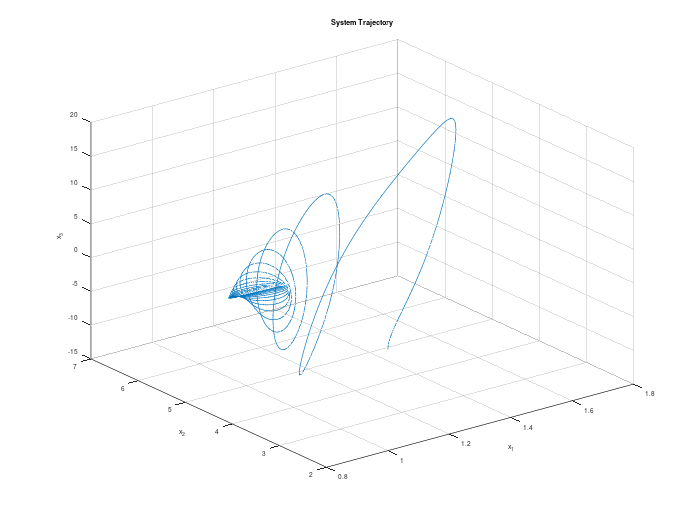

In [12]:
plot3(x(:,1),x(:,2),x(:,3)); grid on
xlabel('x_1'); ylabel('x_2'); zlabel('x_3')
title('System Trajectory')